eng_tokenized
- 문장의 단어들을 토큰화한 리스트  
[["I'm", 'Yooyang.'], ["Ms.", "Yooyang,", "are", "you", "Chinese?"]...]

eng_word2count
- 각 단어의 등장 횟수를 센 리스트  
[('I', 392), ('to', 361), ('the', 319)...]

eng_word_to_idx
- 각 단어에 index를 준 딕셔너리  
{'<pad>': 0, '<unk>': 1, ... }

eng_vocab
- 단어 모음  
['<pad>', '<unk>', ... ]

eng_encoded
- 문장을 토큰 인덱스로 encoding한 리스트  
예시) <'bos'>['Ms.', 'Yooyang,', 'are', 'you', 'Chinese?']<'eos'> --->  [2, 76, 535, 16, 8, 536, 3]

dataloader
- batch_size에 맞게 각 sequence를 padding 한 리스트

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. Load [Korean - English Parallel Corpus](https://www.kaggle.com/datasets/rareloto/naver-dictionary-conversation-of-the-day) Data

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# 파일 경로
file_path = '/content/drive/MyDrive/Colab Notebooks/2024-2 딥러닝/기말 프로젝트/Korean - English Parallel Corpus.csv'

# CSV 파일 읽기
data = pd.read_csv(file_path)

data.head()

,date,kor_title,eng_title,grammar,grammar_desc
0,20171204,저는 유양이에요.,I'm Yooyang.,N은/는¹ N이에요/예요.,N is the noun. '은/는' is used with a noun to de...
1,20171205,유양 씨는 중국 사람이에요?,"Ms. Yooyang, are you Chinese?",N은/는 N이에요/예요?,It is the interrogative form of 'N은/는 N이에요/예요'.
2,20171206,저는 학생이 아니에요.,I'm not a student.,N은/는 N이/가¹ 아니에요.,It is the negation of 'N은/는 N이에요/예요'. When the...
3,20171207,저 사람은 흐엉 씨예요.,That person is Ms. Huong.,이/그/저 N은/는 N이에요/예요.,이' is used in front of a noun to refer to some...
4,20171208,다니엘 씨는 스티브 씨의 남동생이에요.,Mr. Daniel is Mr. Steve's younger brother.,N은/는 N의 N이에요/예요.,의' is the particle used to make possessive for...


In [16]:
data.info() # 849개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849 entries, 0 to 848
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          849 non-null    int64 
 1   kor_title     849 non-null    object
 2   eng_title     849 non-null    object
 3   grammar       849 non-null    object
 4   grammar_desc  844 non-null    object
dtypes: int64(1), object(4)
memory usage: 33.3+ KB


In [17]:
# 영어와 한국어 문장 추출
eng_texts = data['eng_title'].tolist()  # 영어 문장
kor_texts = data['kor_title'].tolist()  # 한국어 문장

In [18]:
eng_texts[:5]

["I'm Yooyang.",
 'Ms. Yooyang, are you Chinese?',
 "I'm not a student.",
 'That person is Ms. Huong.',
 "Mr. Daniel is Mr. Steve's younger brother."]

In [19]:
kor_texts[:5]

['저는 유양이에요.',
 '유양 씨는 중국 사람이에요?',
 '저는 학생이 아니에요.',
 '저 사람은 흐엉 씨예요.',
 '다니엘 씨는 스티브 씨의 남동생이에요.']

## 2. Tokenization

In [20]:
def tokenize_sentence(sentence: str) -> list[str]: # 함수의 입력과 출력 데이터 타입을 명시. sentence는 str type이며, 함수 출력값은 문자열을 요소로 갖는 list
    return sentence.split(' ')

In [21]:
eng_texts[0]

"I'm Yooyang."

In [22]:
tokenize_sentence(eng_texts[0])

["I'm", 'Yooyang.']

In [23]:
eng_tokenized = [tokenize_sentence(t) for t in eng_texts] # 문장의 단어가 토큰화되어 리스트로 들어감
kor_tokenized = [tokenize_sentence(t) for t in kor_texts]

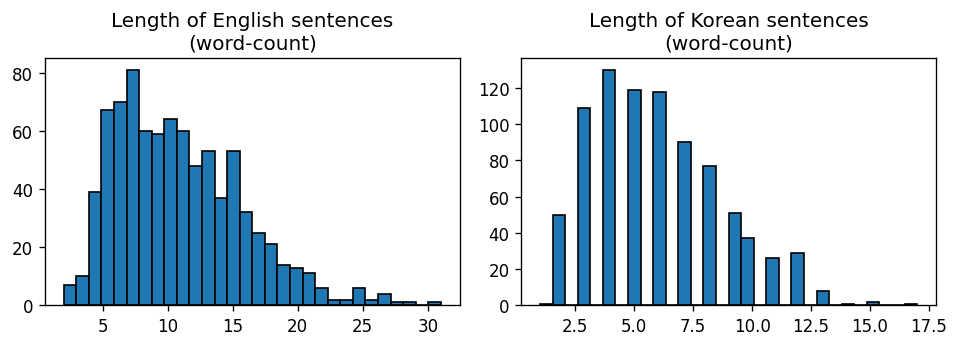

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=120)

axes[0].hist([len(s) for s in eng_tokenized], bins=30, edgecolor='k')
axes[0].set_title("Length of English sentences\n(word-count)")

axes[1].hist([len(s) for s in kor_tokenized], bins=30, edgecolor='k')
axes[1].set_title("Length of Korean sentences\n(word-count)")

plt.tight_layout()
plt.show()

## 3. Build Vocabulary

In [25]:
from collections import Counter

In [26]:
# eng_tokenized에서 sentence를 받고, sentence에서 token을 받은 후에 Counter로 각 단어의 등장 횟수를 센다.
eng_word2count = Counter(token for sentence in eng_tokenized for token in sentence)
kor_word2count = Counter(token for sentence in kor_tokenized for token in sentence)

eng_word2count.most_common(10) # 내림차순 10개

[('I', 392),
 ('to', 361),
 ('the', 319),
 ('a', 285),
 ('you', 177),
 ('is', 141),
 ('it', 114),
 ('of', 104),
 ('that', 100),
 ('have', 94)]

In [27]:
print(f"Number of unique words in English corpus: {len(eng_word2count):,}")
print(f"Number of unique words in Korean corpus: {len(kor_word2count):,}")

Number of unique words in English corpus: 2,156
Number of unique words in Korean corpus: 2,688


In [28]:
special_tokens = [
    '<pad>',  # padding token
    '<unk>',  # unknown token for out-of-vocab words
    '<bos>',  # beginning of sequence
    '<eos>',  # end of sequence
]

eng_word_to_idx = {}
kor_word_to_idx = {}

# 1. Add special tokens
for i, token in enumerate(special_tokens):
    eng_word_to_idx[token] = i
    kor_word_to_idx[token] = i

# 2-1. Add the remaining words(English)
i = len(eng_word_to_idx)  # 4
for word, count in eng_word2count.most_common(): # most_common -> 등장 횟수 내림차순
    if word not in eng_word_to_idx:
        eng_word_to_idx[word] = i # 단어에 index 주기
        i += 1

# 2-2. Add the remaining words(Korean)
i = len(kor_word_to_idx)  # 4
for word, count in kor_word2count.most_common(): # most_common -> 등장 횟수 내림차순
    if word not in kor_word_to_idx:
        kor_word_to_idx[word] = i # 단어에 index 주기
        i += 1

print(len(eng_word_to_idx), '-', eng_word_to_idx)
print(len(kor_word_to_idx), '-', kor_word_to_idx)

2160 - {'<pad>': 0, '<unk>': 1, '<bos>': 2, '<eos>': 3, 'I': 4, 'to': 5, 'the': 6, 'a': 7, 'you': 8, 'is': 9, 'it': 10, 'of': 11, 'that': 12, 'have': 13, 'my': 14, 'in': 15, 'are': 16, 'and': 17, 'on': 18, 'go': 19, 'for': 20, 'like': 21, 'be': 22, 'not': 23, 'but': 24, 'will': 25, 'so': 26, 'because': 27, 'your': 28, 'going': 29, 'It': 30, 'at': 31, 'The': 32, 'do': 33, "It's": 34, 'we': 35, 'was': 36, 'an': 37, 'as': 38, 'am': 39, 'get': 40, 'You': 41, "I'm": 42, "don't": 43, 'would': 44, 'this': 45, 'with': 46, 'from': 47, 'about': 48, 'can': 49, 'take': 50, 'should': 51, 'good': 52, 'My': 53, 'there': 54, "it's": 55, 'they': 56, 'eat': 57, 'been': 58, 'If': 59, 'if': 60, 'There': 61, 'make': 62, 'lot': 63, 'it.': 64, 'What': 65, 'what': 66, 'me': 67, 'also': 68, 'want': 69, 'come': 70, 'seems': 71, 'How': 72, 'Please': 73, 'them': 74, 'people': 75, 'Ms.': 76, 'many': 77, 'time': 78, 'one': 79, 'or': 80, 'more': 81, 'when': 82, 'know': 83, 'these': 84, 'buy': 85, 'all': 86, 'feel': 

In [29]:
eng_word_to_idx["I"] # I의 index = 4

4

In [30]:
eng_word2count['I'] # I의 등장 횟수

392

In [31]:
eng_vocab = list(eng_word_to_idx.keys())
kor_vocab = list(kor_word_to_idx.keys())

print(eng_vocab[:10])
print(kor_vocab[:10])

['<pad>', '<unk>', '<bos>', '<eos>', 'I', 'to', 'the', 'a', 'you', 'is']
['<pad>', '<unk>', '<bos>', '<eos>', '저는', '것', '있어요.', '안', '수', '좀']


## 4. Encode Text Using the Vocabulary
- You can now encode sentences into sequences of token indices.

In [32]:
def encode_sentence(sentence, word_to_idx):
    tokens = ['<bos>'] + sentence + ['<eos>']  # <bos>, token1, token2, ..., <eos>
    unk_idx = word_to_idx['<unk>']             # '<unk>의 index = 1 -> unk_idx = 1
    return [word_to_idx.get(t, unk_idx) for t in tokens] # get 함수는 dictionary에서 t에 대응하는 값을 가져오고, 값이 없으면 unk_idx를 반환한다.

In [33]:
"""
    Apply the `encode_sentence` function to the entire training data.
"""

eng_encoded = [encode_sentence(sent, eng_word_to_idx) for sent in eng_tokenized]
kor_encoded = [encode_sentence(sent, kor_word_to_idx) for sent in kor_tokenized]

print(f"English sentence: '<bos>'{eng_tokenized[1]}'eos'")
print(f"Encoded sentence: {eng_encoded[1]}")
print(f"Korean sentence: '<bos>'{kor_tokenized[1]}'eos'")
print(f"Encoded sentence: {kor_encoded[1]}")

English sentence: '<bos>'['Ms.', 'Yooyang,', 'are', 'you', 'Chinese?']'eos'
Encoded sentence: [2, 76, 535, 16, 8, 536, 3]
Korean sentence: '<bos>'['유양', '씨는', '중국', '사람이에요?']'eos'
Encoded sentence: [2, 93, 35, 155, 341, 3]


## 5. Padding

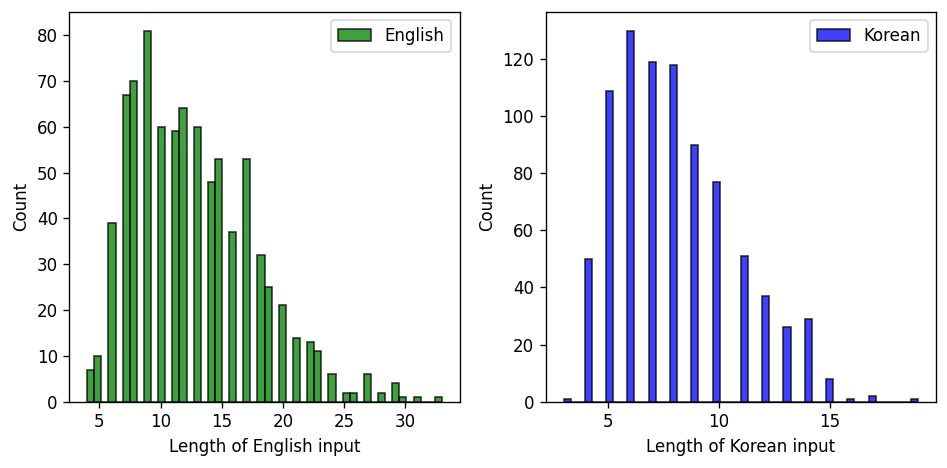

In [34]:
import matplotlib.pyplot as plt

# 텍스트 길이 계산
eng_text_lengths = [len(seq) for seq in eng_encoded]
kor_text_lengths = [len(seq) for seq in kor_encoded]

# 서브플롯 설정 (1행 2열)
plt.figure(figsize=(8, 4), dpi=120)

# 첫 번째 서브플롯: 영어 텍스트 길이 히스토그램
plt.subplot(1, 2, 1)  # (행, 열, 위치)
plt.hist(eng_text_lengths, bins=50, label='English', alpha=0.75, facecolor='g', edgecolor='k')
plt.xlabel('Length of English input')
plt.ylabel('Count')
plt.legend()

# 두 번째 서브플롯: 한국어 텍스트 길이 히스토그램
plt.subplot(1, 2, 2)  # (행, 열, 위치)
plt.hist(kor_text_lengths, bins=50, label='Korean', alpha=0.75, facecolor='b', edgecolor='k')
plt.xlabel('Length of Korean input')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()

plt.show()

In [35]:
# 패딩 (고정된 시퀀스 길이 사용)
max_eng_len = max(len(seq) for seq in eng_encoded) #  모든 시퀀스 중에서 가장 긴 시퀀스의 길이 찾기
max_kor_len = max(len(seq) for seq in kor_encoded)

print(f'영어 최대 시퀀스 길이: {max_eng_len}')
print(f'한국어 최대 시퀀스 길이: {max_kor_len}')

영어 최대 시퀀스 길이: 33
한국어 최대 시퀀스 길이: 19


In [36]:
# from tensorflow.keras.preprocessing.sequence import pad_sequences
eng_padded = pad_sequences(eng_encoded, maxlen=max_eng_len, padding='post') # maxlen = 각 시퀀스 길이 지정, padding='post': sequence 뒤쪽에 패딩
kor_padded = pad_sequences(kor_encoded, maxlen=max_eng_len, padding='post') # 영어/한국어 모든 데이터 중에 가장 긴 sequence로 패딩

In [37]:
print(eng_padded.shape)
print(eng_padded) # 영어

(849, 33)
[[  2  42 534 ...   0   0   0]
 [  2  76 535 ...   0   0   0]
 [  2  42  23 ...   0   0   0]
 ...
 [  2 305 138 ...   0   0   0]
 [  2   4  43 ...   0   0   0]
 [  2  34 828 ...   0   0   0]]


In [38]:
print(kor_padded.shape)
print(kor_padded) # 한국어

(849, 33)
[[  2   4 340 ...   0   0   0]
 [  2  93  35 ...   0   0   0]
 [  2   4 342 ...   0   0   0]
 ...
 [  2 210  55 ...   0   0   0]
 [  2 166 201 ...   0   0   0]
 [  2 779 780 ...   0   0   0]]


## 6. Create PyTorch Datasets

#### Change dtype to tensor

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader

In [40]:
class PairedDataset(Dataset):
  def __init__(self, eng_data, kor_data):
    self.eng_data = eng_data # vocab 단어로 인코딩된 영어 문장 리스트
    self.kor_data = kor_data

  def __len__(self):
    return len(self.eng_data)

  def __getitem__(self, idx):
    eng_data_tensor = torch.tensor(self.eng_data[idx], dtype=torch.long)  # 텐서로 변환
    kor_data_tensor = torch.tensor(self.kor_data[idx], dtype=torch.long)  # 텐서로 변환
    return eng_data_tensor, kor_data_tensor  # inputs와 labels로 반환

In [41]:
dataset = PairedDataset(eng_padded, kor_padded)

In [42]:
print(f"'<bos>'{eng_tokenized[1]}'<eos>', <bos>'{kor_tokenized[1]}'<eos>'")
print(dataset[1])

'<bos>'['Ms.', 'Yooyang,', 'are', 'you', 'Chinese?']'<eos>', <bos>'['유양', '씨는', '중국', '사람이에요?']'<eos>'
(tensor([  2,  76, 535,  16,   8, 536,   3,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0]), tensor([  2,  93,  35, 155, 341,   3,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0]))


In [43]:
# shuffle=True -> 데이터를 무작위로 섞어 모델이 특정 순서나 패턴에 의존하지 않도록 함
# 마지막 batch의 데이터 batch_size보다 작을 경우 그 배치는 학습에 포함하지 않음

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

<h1><b>7. Defining the RNN translation model</h1></b>

In [44]:
import torch
import torch.nn as nn

# Hyperparameters
input_size = len(eng_vocab)  # 어휘 크기
output_size = len(kor_vocab)  # 한국어 어휘 크기
embedding_dim = 256 # 임베딩 차원
hidden_dim = 256  # RNN의 히든 차원
num_layers = 1  # RNN 레이어 수

class RNNTranslationModel(nn.Module):
    def __init__(self, input_size, output_size, embedding_dim, hidden_dim, num_layers):
        super(RNNTranslationModel, self).__init__()

        # 임베딩 층: 단어를 벡터로 변환
        self.embedding = nn.Embedding(input_size, embedding_dim) # 어휘와 임베딩 차원 설정

        # RNN 층: 입력을 시퀀스 형식으로 처리
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)

        # 출력 층: RNN의 출력을 단어 인덱스로 변환
        self.fc_out = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        # 입력을 임베딩
        embedded = self.embedding(x)

        # RNN 처리
        output, hidden = self.rnn(embedded) # output(RNN의 출력)과 hidden(최종 숨겨진 상태)을 얻음

        # RNN 출력을 출력층에 전달하여 각 시간 단계에서의 예측을 얻습니다.
        output = self.fc_out(output)

        return output

# 모델 초기화
model = RNNTranslationModel(input_size, output_size, embedding_dim, hidden_dim, num_layers)

In [45]:
# 손실 함수: 크로스 엔트로피 손실
criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore_index=0 -> 패딩 인덱스 무시

# 옵티마이저
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [46]:
# 훈련 함수

dataset = PairedDataset(
    eng_padded,
    kor_padded
)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

def train(model, dataloader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 모델을 훈련 모드로 설정
        total_loss = 0

        for i, batch in enumerate(dataloader):
            optimizer.zero_grad()  # 기울기 초기화

            input_seq, output_seq = batch
            if torch.cuda.is_available():
              input_seq = input_seq.to('cuda')
              output_seq = output_seq.to('cuda')

            # 모델에 입력하여 예측 값 얻기
            # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#crossentropyloss
            logits = model(input_seq)  # (B, T, V)
            logits = logits.permute(0, 2, 1)   # (B, V, T); 클래스 차원이 dim=1에 위치해야 함. logits.permute_ 에러 -> logits.permute

            # 손실 계산 (배치 차원에서)
            loss = criterion(
                logits,     # (B, V, T)
                output_seq  # (B, T)
                )

            # 손실 역전파
            loss.backward()
            optimizer.step()  # 가중치 업데이트

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")

# 훈련 시작
train(model, dataloader, criterion, optimizer, num_epochs=10)

Epoch [1/10], Loss: 6.7476
Epoch [2/10], Loss: 5.5623
Epoch [3/10], Loss: 4.9860
Epoch [4/10], Loss: 4.4612
Epoch [5/10], Loss: 3.9229
Epoch [6/10], Loss: 3.4133
Epoch [7/10], Loss: 2.9559
Epoch [8/10], Loss: 2.5216
Epoch [9/10], Loss: 2.1546
Epoch [10/10], Loss: 1.8561


## Train, Test, Validation data 나누고 model 훈련

In [47]:
from sklearn.model_selection import train_test_split

# 훈련, 검증, 테스트 데이터 분리 (80%, 10%, 10%)
train_data, test_data = train_test_split(list(zip(eng_padded, kor_padded)), test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=42)  # 0.125 * 0.8 = 0.1

# PairedDataset으로 변환
train_dataset = PairedDataset(*zip(*train_data))
val_dataset = PairedDataset(*zip(*val_data))
test_dataset = PairedDataset(*zip(*test_data))

In [48]:
# DataLoader 설정
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [49]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # 모델을 훈련 모드로 설정
        total_loss = 0

        # 훈련 데이터셋에 대해 훈련
        for i, batch in enumerate(train_dataloader):
            optimizer.zero_grad()  # 기울기 초기화

            input_seq, output_seq = batch
            if torch.cuda.is_available():
                input_seq = input_seq.to('cuda')
                output_seq = output_seq.to('cuda')

            # 모델에 입력하여 예측 값 얻기
            logits = model(input_seq)  # (B, T, V)
            logits = logits.permute(0, 2, 1)   # (B, V, T); 클래스 차원이 dim=1에 위치해야 함

            # 손실 계산
            loss = criterion(logits, output_seq)  # (B, V, T), (B, T)

            # 손실 역전파
            loss.backward()
            optimizer.step()  # 가중치 업데이트

            total_loss += loss.item()

        # 훈련 손실 출력
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_dataloader):.4f}")

        # 검증 손실 계산
        model.eval()  # 모델을 평가 모드로 설정
        total_val_loss = 0
        with torch.no_grad():  # 검증 중에는 기울기를 계산하지 않음
            for val_batch in val_dataloader:
                input_seq, output_seq = val_batch
                if torch.cuda.is_available():
                    input_seq = input_seq.to('cuda')
                    output_seq = output_seq.to('cuda')

                logits = model(input_seq)  # (B, T, V)
                logits = logits.permute(0, 2, 1)   # (B, V, T)

                val_loss = criterion(logits, output_seq)
                total_val_loss += val_loss.item()

        # 검증 손실 출력
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {total_val_loss/len(val_dataloader):.4f}")

In [50]:
def evaluate(model, test_dataloader, criterion):
    model.eval()  # 모델을 평가 모드로 설정
    total_test_loss = 0
    with torch.no_grad():  # 기울기를 계산하지 않음
        for test_batch in test_dataloader:
            input_seq, output_seq = test_batch
            if torch.cuda.is_available():
                input_seq = input_seq.to('cuda')
                output_seq = output_seq.to('cuda')

            logits = model(input_seq)  # (B, T, V)
            logits = logits.permute(0, 2, 1)   # (B, V, T)

            test_loss = criterion(logits, output_seq)
            total_test_loss += test_loss.item()

    print(f"Test Loss: {total_test_loss/len(test_dataloader):.4f}")

In [51]:
# 훈련 시작
train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10)

# 테스트 데이터로 모델 평가
evaluate(model, test_dataloader, criterion)

Epoch [1/10], Loss: 1.5693
Epoch [1/10], Validation Loss: 1.6341
Epoch [2/10], Loss: 1.3234
Epoch [2/10], Validation Loss: 1.7488
Epoch [3/10], Loss: 1.1410
Epoch [3/10], Validation Loss: 1.8466
Epoch [4/10], Loss: 1.0104
Epoch [4/10], Validation Loss: 1.9163
Epoch [5/10], Loss: 0.9032
Epoch [5/10], Validation Loss: 1.9846
Epoch [6/10], Loss: 0.8236
Epoch [6/10], Validation Loss: 2.0585
Epoch [7/10], Loss: 0.7614
Epoch [7/10], Validation Loss: 2.0966
Epoch [8/10], Loss: 0.7119
Epoch [8/10], Validation Loss: 2.1504
Epoch [9/10], Loss: 0.6681
Epoch [9/10], Validation Loss: 2.1869
Epoch [10/10], Loss: 0.6355
Epoch [10/10], Validation Loss: 2.2314
Test Loss: 2.2036


## Early Stopping

In [52]:
import torch

# 훈련 함수
def train_with_early_stopping(model, dataloader, criterion, optimizer, num_epochs=10, patience=3):
    best_loss = float('inf')  # 가장 낮은 검증 손실을 추적
    epochs_without_improvement = 0  # 개선되지 않은 에포크 수 추적

    for epoch in range(num_epochs):
        model.train()  # 모델을 훈련 모드로 설정
        total_loss = 0

        # 훈련 데이터에 대해 훈련
        for i, batch in enumerate(dataloader):
            optimizer.zero_grad()  # 기울기 초기화

            input_seq, output_seq = batch
            if torch.cuda.is_available():
                input_seq = input_seq.to('cuda')
                output_seq = output_seq.to('cuda')

            logits = model(input_seq)  # (B, T, V)
            logits = logits.permute(0, 2, 1)  # (B, V, T); 클래스 차원이 dim=1에 위치해야 함

            loss = criterion(logits, output_seq)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트

            total_loss += loss.item()

        # 에포크당 평균 손실 출력
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # 검증 손실 계산 (여기서는 훈련 중 검증 데이터를 추적한다고 가정)
        model.eval()  # 모델을 평가 모드로 설정
        with torch.no_grad():  # 그래디언트 계산 방지
            total_val_loss = 0
            for i, batch in enumerate(val_dataloader):  # val_dataloader는 검증용 데이터 로더
                input_seq, output_seq = batch
                if torch.cuda.is_available():
                    input_seq = input_seq.to('cuda')
                    output_seq = output_seq.to('cuda')

                logits = model(input_seq)
                logits = logits.permute(0, 2, 1)

                val_loss = criterion(logits, output_seq)
                total_val_loss += val_loss.item()

            avg_val_loss = total_val_loss / len(val_dataloader)
            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

            # 검증 손실이 개선되지 않으면 에포크 수 증가
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                epochs_without_improvement = 0  # 개선되었으므로 카운트를 리셋
            else:
                epochs_without_improvement += 1

            # 개선이 없으면 조기 종료
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

# 훈련 시작
train_with_early_stopping(model, dataloader, criterion, optimizer, num_epochs=10, patience=3)


Epoch [1/10], Loss: 1.0963
Epoch [1/10], Validation Loss: 1.5658
Epoch [2/10], Loss: 0.9033
Epoch [2/10], Validation Loss: 1.0656
Epoch [3/10], Loss: 0.7837
Epoch [3/10], Validation Loss: 0.8258
Epoch [4/10], Loss: 0.7133
Epoch [4/10], Validation Loss: 0.6813
Epoch [5/10], Loss: 0.6734
Epoch [5/10], Validation Loss: 0.6054
Epoch [6/10], Loss: 0.6381
Epoch [6/10], Validation Loss: 0.5763
Epoch [7/10], Loss: 0.6147
Epoch [7/10], Validation Loss: 0.5234
Epoch [8/10], Loss: 0.5976
Epoch [8/10], Validation Loss: 0.4899
Epoch [9/10], Loss: 0.5863
Epoch [9/10], Validation Loss: 0.4834
Epoch [10/10], Loss: 0.5747
Epoch [10/10], Validation Loss: 0.4531


In [85]:
# 영어 문장을 받아서 번역하는 함수
def translate(model, eng_sentence, eng_word_to_idx, kor_word_to_idx, device='cuda'):
    # 1. 입력 문장 전처리 (영어 문장을 정수 인덱스로 변환)
    eng_tokens = eng_sentence.split()  # 공백을 기준으로 토큰화
    eng_indices = [eng_word_to_idx.get(token, eng_word_to_idx['<unk>']) for token in eng_tokens]  # 어휘에 맞는 인덱스로 변환

    # 2. 모델에 입력하기 위해 텐서로 변환하고 패딩 추가
    device = torch.device('cpu') # RuntimeError: Found no NVIDIA driver on your system. -> cpu로 실행
    eng_tensor = torch.tensor(eng_indices).unsqueeze(0).to(device)  # 배치 차원 추가 (1, T)

    # 3. 모델을 평가 모드로 설정하고 예측
    model.eval()  # 평가 모드로 설정
    with torch.no_grad():
        output = model(eng_tensor)  # (B, T, V)
        output = output.argmax(dim=2)  # 예측된 단어 인덱스 (B, T)

    # 4. 예측된 인덱스를 한국어 문장으로 변환
    pred_tokens = [list(kor_word_to_idx.keys())[list(kor_word_to_idx.values()).index(idx.item())] for idx in output[0]] # 인덱스를 다시 단어로 변환
    pred_sentence = ' '.join(pred_tokens)

    return pred_sentence

In [114]:
# 예시 문장
eng_sentence = "I love you"
pred_kor_sentence = translate(model, eng_sentence, eng_word_to_idx, kor_word_to_idx)
print(f"Input (English): {eng_sentence}")
print(f"Predicted (Korean): {pred_kor_sentence}")

Input (English): I love you
Predicted (Korean): 약속을 하는 <eos>
